# Notebook for meaning and variation



In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import json
import requests
from IPython.display import HTML
import seaborn as sns
from scipy.spatial.distance import cosine

sns.set_style('white')
%matplotlib inline

 ## Programkode (aktiver og gå forbi...)

In [1]:
def get_konk(word, params=dict(), kind='html'):
    import requests
    import pandas as pd
    
    para = params
    para['word']= word

    corpus = 'bok'
    if 'corpus' in para:
        corpus = para['corpus']
    else:
        para['corpus'] = corpus
        
    r = requests.get('https://api.nb.no/ngram/konk', params=para)
    if kind=='html':
        rows = ""
        if corpus == 'bok':
            for x in r.json():
                rows += """<tr>
                <td>
                    <a href='{urn}' target='_'>{urnredux}</a>
                    <td>{b}</td>
                    <td>{w}</td>
                    <td style='text-align:left'>{a}</td>
                    </tr>\n""".format(urn=x['urn'], 
                                      urnredux=','.join([x['author'], x['title'], str(x['year'])]),
                                      b=x['before'],
                                      w=x['word'],
                                      a=x['after']
                                     )
            res = "<table>{rows}</table>".format(rows=rows)   
        else:
            #print(r.json())
            for x in r.json():
                rows += """<tr>
                <td>
                    <a href='{urn}' target='_'>{urnredux}</a>
                    <td>{b}</td>
                    <td>{w}</td>
                    <td style='text-align:left'>{a}</td>
                    </tr>\n""".format(urn=x['urn'], 
                                      urnredux=x['urn'],
                                      b=x['before'],
                                      w=x['word'],
                                      a=x['after']
                                     )
            res = "<table>{rows}</table>".format(rows=rows)   
    elif kind == 'json':
        res = r.json()
    else:
        try:
            if corpus == 'bok':
                res = pd.DataFrame(r.json())
                res = res[['urn','author','title','year','before','word','after']]
            else:
                res = pd.DataFrame(r.json())
                res = res[['urn','before','word','after']]
            
        except:
            res= pd.DataFrame()
        #r = r.style.set_properties(subset=['after'],**{'text-align':'left'})
    return res

def konk_to_html(jsonkonk):
    rows = ""
    for x in jsonkonk:
        rows += "<tr><td><a href='{urn}' target='_'>{urnredux}</a><td>{b}</td><td>{w}</td><td style='text-align:left'>{a}</td></tr>\n".format(urn=x['urn'],
                                                                                                          urnredux=x['urn'],
                                                                                                          b=x['before'],
                                                                                                      w=x['word'],
                                                                                                          a=x['after'])
    res = "<table>{rows}</table>".format(rows=rows)   
    return res

def get_urnkonk(word, params=dict()):
    import requests
    import pandas as pd
    
    para = params
    para['word']= word
    r = requests.post('https://api.nb.no/ngram/urnkonk', json=para)
    r = pd.DataFrame(r.json())
    r = r[['urn','before','word','after']]
    #r = r.style.set_properties(subset=['after'],**{'text-align':'left'})
    return r
    
def get_ngram(word, params=dict()):
    import requests
    import pandas as pd
    
    para = params
    para['word']= word
    r = requests.get('https://api.nb.no/ngram/ngram', params=para)
    r = pd.DataFrame.from_dict(r.json(), orient='index').sort_index()
    #r.columns = [word]
    return r

def conc_counts_tot(mns):
    mc = dict()
    for key in mns:
        lkey = '{f}-{t}'.format(f=key[0],t=key[1])
        mc[lkey] = Counter()
        if not(mns[key].empty):
            for x in mns[key]['after']:
                if x != None:
                    mc[lkey].update(x.split())
            for x in mns[key]['before']:
                if x != None:
                    mc[lkey].update(x.split())        
    return mc


def relativize(c_obj, gtot=20000000000, unigram = {}):
    import sqlite3
    from collections import Counter
    import numpy as np
    
    res = Counter()
    smalltot = sum(c_obj.values())
    with sqlite3.connect(unigram) as con:
        cur = con.cursor()
        for key in c_obj:
            val = cur.execute("select freq from unigram where first=?", (key,)).fetchall()
            if val != []:
                res[key] =np.log2(c_obj[key]) * np.log2((c_obj[key]/val[0][0])*(gtot/smalltot))
    return res

def plotrelative(ng1, ng2, period=(1850, 2005), window=2, figsize=(15,8), ymin=0, legend=False):
    import matplotlib.pyplot as plt
      
    (ng1/ng2).loc[str(period[0]):str(period[1])].rolling(window, win_type='triang').mean().plot(legend=legend, figsize=figsize);
    fymin, fymax = plt.ylim()
    plt.ylim(ymin, fymax)
    return

def heatmap(df, color='green'):
    return df.fillna(0).style.background_gradient(cmap=sns.light_palette(color, as_cmap=True))
    
def cosines(fotodf):
    cosfoto = Counter()
    done = []
    for x in fotodf.columns:
        done.append(x)
        for y in fotodf.columns:
            if y not in done:
                cosfoto[(x,y)] = (1 - cosine(fotodf[x], fotodf[y]))
    return cosfoto.most_common()            
    
def periods(p_start, p_end, step):
    årstall = list(range(p_start, p_end, step))
    ypairs = []
    for i in range(len(årstall) - 1):
        ypairs.append((årstall[i], årstall[i+1]))
    return ypairs
    
def barplot(df):
    df.fillna(0).plot(kind='bar',figsize=(15,8), color= sns.hls_palette(len(df), l=.4, s=.9));
    return 

def dewey_dist(word):
    res = dict()
    for i in range(10):
        dta = get_ngram(word, params={'corpus':'bok','ddk':i}).sum()
        res[str(i*100)] = dta
    return res

def js_delta(js1, js2):
    # Arguments as json, output a dataframe
    return pd.DataFrame.from_dict(js1, orient='index')/pd.DataFrame.from_dict(js2, orient='index')


In [8]:
def analyse_konk( word, subset, periods, params):
    #para_totals = totals(periods, params)
    embed = dict()
    for w in subset:
        embed[w] = get_ngram(w, params=params)
    counts = dict()
    for w in embed:
        period_counts = dict()
        for p in periods:
            period_counts[(p[0],p[1])] = embed[w].loc[str(p[0]):str(p[1])].sum()
        counts[w] = period_counts
#    for (yf, yt) in periods:
#        mns[(yf, yt)] = get_konk(word, kind='', params = params)
    return counts

def totals(periods, params):
    words = 'i og . ,'.split()
    totals = dict()
    for w in words:
        totals[w] = get_ngram(w, params=params)
    counts = dict()
    for w in totals:
        period_counts = dict()
        for p in periods:
            period_counts[(p[0],p[1])] = totals[w].loc[str(p[0]):str(p[1])].sum()
        counts[w] = period_counts
    return pd.DataFrame(pd.DataFrame(counts).sum(axis=1)*7)

def totals2(periods, params):
    words = 'i og . ,'.split()
    year_tot = total_year(params)
    counts = dict()
    period_counts = dict()
    for p in periods:
        period_counts[(p[0],p[1])] = year_tot.loc[str(p[0]):str(p[1])].sum()
    return pd.DataFrame.from_dict(period_counts,orient='index')

def total_year(params):
    words = 'i og . ,'.split()
    wcount = dict()
    for w in words:
        wcount[w] = get_ngram(w, params=params)
    return (((wcount['.']+wcount['og']).fillna(0) + wcount[',']).fillna(0) + wcount['i'])*6
    
total_avis = total_year({'corpus':'avis'})

def rel_word (word, params, relativ=total_avis):
    """Computes relative frequency based on counts in total_counts which must be present"""
    w = get_ngram(word, params)
    return w/relativ
    

In [9]:
def conc_count(konk_jsonarray, mode='relative'):
    """Concordances contain attributes {word: after: before:}, with mode relative, relative counts are returned"""
    counts = Counter()
    for konk in konk_jsonarray:
        counts.update(konk['before'].split())
        counts.update(konk['after'].split())
    if mode == 'relative':
        totals = sum(counts.values())
        for x in counts:
            counts[x] = counts[x]/totals
    return counts

In [43]:
import numpy as np

def check_words(words, konkcount, params, period, comparo):
    score = Counter()
    normalize = comparo.loc[period[0]:period[1]].sum()
    print(normalize)
    for w in words:
        w_data = get_ngram(w, params)
        w_data_sum = w_data.loc[period[0]:period[1]].sum()
        w_period = w_data_sum/normalize
        print(w_period)
        score[w] = np.log2(konkcount[w]/w_period)
    return score
        

In [37]:
def check_words2(konkordans, words, period):
    return check_words(words, konkordans, {'corpus':'avis'},period, total_avis)

In [12]:
def show_gruppe(g):
    return pd.DataFrame(g).transpose().sort_values(by=0, ascending=False)

In [16]:
helse = rel_word('helse',{'corpus':'avis'})

In [14]:
total_avis

,0
1763,16344
1764,99540
1765,22482
1766,94800
1767,327804
1768,388920
1769,372024
1770,371382
1771,379098
1772,421392


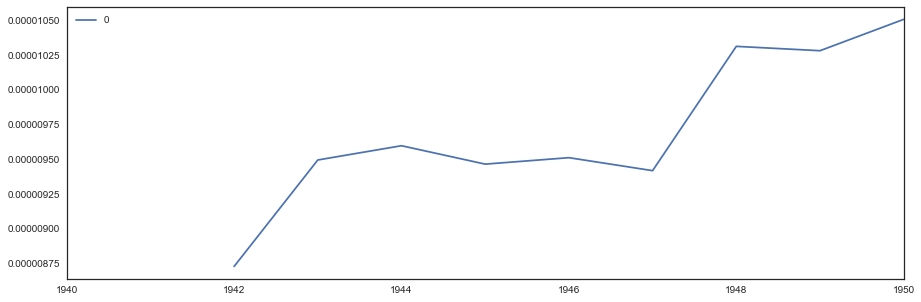

In [36]:
helse.loc['1940':'1950'].rolling(window=3).mean().plot(figsize=(15,5))

## Examine a word

Fill inn a value for corpus and test word

In [19]:
helsedata = """Helse: velferd
Kreft: leukemi, lungekreft, tarmkreft, lymfekreft
Respirator: astma, hoste, kikhoste""".split('\n')
helsegrupper = dict()
for x in helsedata:
    d = x.split(':')
    helsegrupper[d[0].strip()] = [w.strip() for w in d[1].split(',')] + [w.strip().capitalize() for w in d[1].split(',')]
helsegrupper


{'Helse': ['velferd', 'Velferd'],
 'Kreft': ['leukemi',
  'lungekreft',
  'tarmkreft',
  'lymfekreft',
  'Leukemi',
  'Lungekreft',
  'Tarmkreft',
  'Lymfekreft'],
 'Respirator': ['astma', 'hoste', 'kikhoste', 'Astma', 'Hoste', 'Kikhoste']}

In [20]:
helseord = [w for g in helsegrupper.values() for w in g]

### Hvordan er avisene?

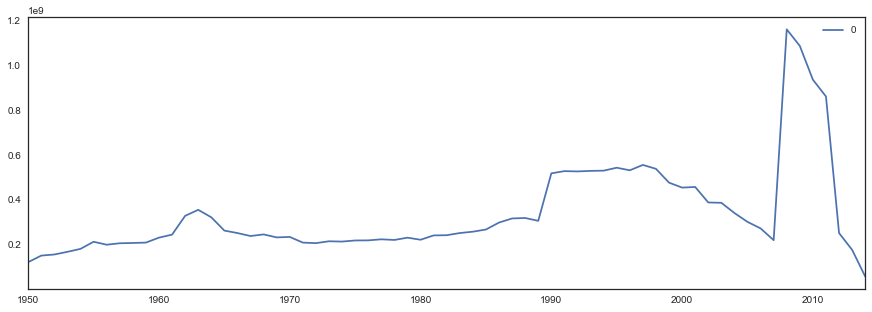

In [25]:
total_avis.loc['1950':].plot(figsize=(15,5));

## Fetch data over periods

The following cells define periods, and fetch a set of concordances for each.


In [27]:
ypairs = periods(1950, 1990, 10)

print(ypairs)
pair_keys = ["{f}-{t}".format(f=x[0],t=x[1]) for  x in ypairs]
print(pair_keys)

[(1950, 1960), (1960, 1970), (1970, 1980)]
['1950-1960', '1960-1970', '1970-1980']


# Build concordances over periods

Parameters are corpus type (here it is pointing to the value of variable _corpus_ that was set in the beginning togethere with *test_word* 

In [28]:
# Hele datasettet legges i variabelen mns

mns = dict()

# loop gjennom hver periode og hent ut konkordanser
words = helseord
for (yf, yt) in ypairs:
    konken = []
    for w in words:
        konk = get_konk(
        w, kind='json', params = {
        'corpus':'avis',
            
        'before':18,
        'after':18,
        'size':400,
        'offset':0,
        'yearfrom':yf, 
        'yearto':yt})
        print(w, len(konk))
        konken += konk
    mns[(yf, yt)] = konken

astma 1449
hoste 3646
kikhoste 2776
Astma 152
Hoste 214
Kikhoste 487
velferd 6007
Velferd 1560
leukemi 440
lungekreft 4276
tarmkreft 22
lymfekreft 0
Leukemi 28
Lungekreft 184
Tarmkreft 3
Lymfekreft 0
astma 3449
hoste 5117
kikhoste 2212
Astma 996
Hoste 373
Kikhoste 372
velferd 7491
Velferd 2182
leukemi 654
lungekreft 6361
tarmkreft 10
lymfekreft 11
Leukemi 44
Lungekreft 293
Tarmkreft 2
Lymfekreft 1
astma 2937
hoste 4875
kikhoste 608
Astma 1144
Hoste 378
Kikhoste 101
velferd 6263
Velferd 1524
leukemi 782
lungekreft 3277
tarmkreft 52
lymfekreft 76
Leukemi 83
Lungekreft 181
Tarmkreft 2
Lymfekreft 0


In [30]:
helsekonk = mns

In [31]:
len(helsekonk)

3

In [33]:
HTML(konk_to_html(helsekonk[(1950,1960)][:100]))

"https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19550401_7_26_1denne omsorgen påforer barnet , ofte gir seg utslag i magesmerter .",astma,", hodepine , oppkast eller visse hudlidelser . Når ungen Overdreven omsorg"
"https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19500331_2_26_1, AvU * - bevdes & være et hoyfehlv ei ! Uot",astma,- influensa og 1 Bad [ f ° r elagt legekongressen Dølehesten
https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19521017_4_74_1vise seg å være nyttig når det gjelder å behandle sykdommer som,astma,og revmatisme . « Kammeret » er et trykk-rom som er luftavkjølt
"https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19521216_4_92_1jærkona heilt ut . Ole var ofte sengeliggjande , han leid av",astma,", og då laut ho bala åleine , men det gjekk ;"
https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19531124_5_83_1derute og peste litt i det råe været . Hun led av,astma,". Je så dora sto oppe , og sa måtte je stikke"
https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19591215_11_89_1denne oren er pappa blitt frisk ig ; en av gikt og,astma,", sier datteren Halldis på giktbekjemperon Reinslis fane . FISKE LNDER HAVFLATEN"
https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19600503_12_33_1av langvegg en i hver husende . Je ; 1 rfart at,astma,"og gikt ofte "" i folge , noe jeg seiv har !"
https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19600503_12_33_1jeg fikk nyss om at man kunne bli kvitt både gikt og,astma,", måtte jcg selvsagt prove å nøytralisere vannstrålingen under mitt eget hus"
https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19600503_12_33_1kjente skiloperkolleg-a Håkon Brusveen Som smågutt led han av både gikt og,astma,", og han var nærmest oppgitt av legene . Da han som"
"https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19600503_12_33_1unggutt begynte å trene på ski , forsvant imidlertid både gikt og",astma,", og Brusveen fortalte til sportsjournalistene at takket være treningen « svettet"
https://beta.nb.no/items/URN:NBN:no-nb_digavis_jaerbladet_null_null_19600503_12_33_1har forlengst revidert sin oppfatning nar det gjelder heibredelsesinetoden for gikt og,astma,. Vi fant ved noyere underspkelse ut at han i ungdomsårene hadde


In [44]:
gruppe = dict()
for key in helsekonk:
    gruppe[key] = check_words2(helsekonk[key], "velferd frisk folkehelsen omsorg".split(), (str(key[0]), str(key[1])))

0    2414544234
dtype: int64
0    0.000003
dtype: float64


TypeError: list indices must be integers or slices, not str